In [22]:
from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg
import itertools

In [3]:
!ls ../../machine-learning-ex3/ex3/

Exercise_3.ipynb  ex3data1.mat      lrCostFunction.m  sigmoid.m
displayData.m     ex3weights.mat    oneVsAll.m        submit.m
ex3.m             fmincg.m          predict.m
ex3_nn.m          lib               predictOneVsAll.m


In [4]:
data = loadmat('../../machine-learning-ex3/ex3/ex3data1.mat')

In [5]:
X = data['X']
y = data['y']

In [6]:
def displayData(data):
    
    _, ax = plt.subplots(10,10,figsize=(10,10))
    for i in range(10):
        for j in range(10):
           ax[i,j].imshow(data[np.random.randint(data.shape[0])].reshape((20,20), order = 'F'))          
           ax[i,j].axis('off')  

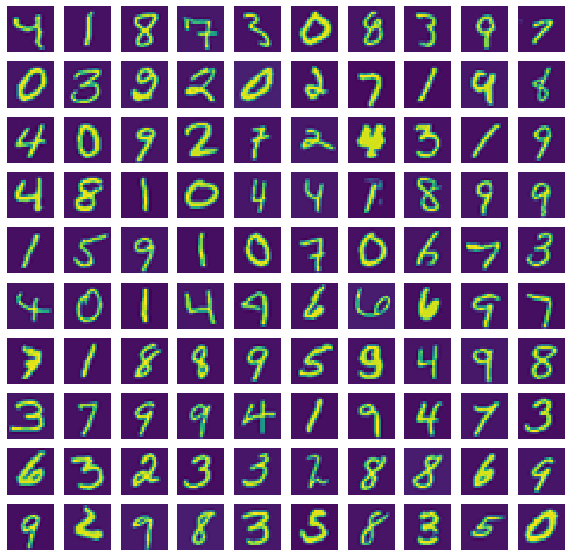

In [7]:
displayData(X)

In [19]:
# load in the pretraine weights

weights = loadmat('ex4weights.mat')
THETA1 = weights['Theta1']
THETA2 = weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
THETA2 = np.roll(THETA2, 1, axis=0)

In [20]:
print(THETA1.shape)
print(THETA2.shape)

(25, 401)
(10, 26)


In [7]:
def apply_sigmoid(value):
    
    result = 1/(1 + np.exp(-value))
    
    return result

In [8]:
def forward_prop(x, thetas):

    preds = X.copy()
    for theta in thetas:
        preds = apply_sigmoid(np.dot(preds, theta.T))
        preds = np.hstack((np.ones((preds.shape[0],1)), preds)) #add in bias
    
    preds = np.delete(preds, 0, 1) #remove bias col
    
    return preds


In [9]:
def add_regularization(thetas, lambd, obs_num):
    
    reg = 0
    for theta in thetas:
        theta = np.multiply(theta[:,1:], theta[:,1:]) # ignore bias
        reg += np.sum(theta)
    
    reg *= (float(lambd)/ (2*obs_num))
    
    return reg

def nnCostFunction(thetas, x, y, k, lambd):
    
    t1 = thetas[:THETA1.shape[0]*THETA1.shape[1]].reshape((THETA1.shape[0],THETA1.shape[1]))
    t2 = thetas[THETA1.shape[0]*THETA1.shape[1]:].reshape((THETA2.shape[0],THETA2.shape[1]))
    thetas_list = [t1, t2]
    
    preds = forward_prop(x, thetas_list)
    # reshape y to [#obs by #class]
    remapped_y = np.array([[1 if val==index else 0 for index in range(k)] for val in y])
    cost_mat = np.multiply(-remapped_y, np.log(preds)) - np.multiply(1-remapped_y, np.log(1-preds))
    cost = cost_mat.sum().sum()/x.shape[0]
    
    # add in regularization
    cost += add_regularization(thetas_list, lambd, x.shape[0])
    
    return cost
    

In [10]:
k = 10
m = X.shape[0]
# add col of 1 to X
X = np.hstack((np.ones((m,1)), X))

In [23]:
lambd = 1

remapped_y = [0 if i==k else i for i in y.flatten()] # assign value 0 if class is 10
weights = flatten_weights([THETA1,THETA2])
nnCostFunction(weights, X, remapped_y, k, lambd)

0.38376985909092365

# Backpropagation

In [13]:
def sigmoidGradient(value):
    
    sig = apply_sigmoid(value)
    
    return sig*(1-sig)

In [14]:
def randInitializeWeights(l_in, l_out, eps_init):
    """
    l_in: incoming connections
    l_out: outgoing connections
    """
    
    W = np.random.rand(l_out, l_in) * 2 * eps_init - eps_init
    
    return W
    

In [15]:
def flatten_weights(mat_list):
    
    flattened = [mat.flatten() for mat in mat_list]
    weights = list(itertools.chain.from_iterable(flattened))
    flattened_array = np.array(weights).reshape((len(weights),1))
    
    return flattened_array
    

In [16]:
def compute_gradient(thetas, x, y, k, lambd):

    
    t1 = thetas[:THETA1.shape[0]*THETA1.shape[1]].reshape((THETA1.shape[0],THETA1.shape[1]))
    t2 = thetas[THETA1.shape[0]*THETA1.shape[1]:].reshape((THETA2.shape[0],THETA2.shape[1]))
    
    thetas = {1:t1, 2:t2}
    
    # ---------------forward--------------- #
    layers = len(list(thetas.keys())) + 1
    a = X.copy()
    activations = {1:a}

    for layer, theta in thetas.items():
        z = np.dot(a, theta.T)
        a = apply_sigmoid(z)
        if layer != len(thetas): # add in bias except for last layer
            a = np.hstack((np.ones((a.shape[0],1)), a))

        activations[layer+1] = a
    
    # ---------------backward--------------- #
    # computing the errors
    # reshape y to [#obs by #class]
    remapped_y = np.array([[1 if val==index else 0 for index in range(k)] for val in y])
    
    # reverse the activation dict to traverse from outter layer
    a_reversed = dict(sorted(list(activations.items()), key=lambda x:x[0], reverse=True))
    errors = {}
    deltas = {} 
    m = x.shape[0] # sample size

    for layer, a_mat in a_reversed.items():
        if layer == list(a_reversed.keys())[0]: # if it's the last layer, just subtract from actual
            errors[layer] = a_mat - remapped_y
        elif layer != 1: # no need to compute error for input layer
            g_prime = np.multiply(a_mat, 1-a_mat)
            errors[layer] = np.multiply(np.dot(thetas[layer].T, errors[layer+1].T).T, g_prime)

    # ------------calculate deltas------------ #
    last_layer = list(activations.keys())[-1]
    for layer, a_mat in activations.items():
        if layer != last_layer: # skip last layer
            # ignores bias
            if layer+1 == last_layer:
                deltas[layer] = np.dot(errors[layer+1].T, a_mat)/m
            else:
                deltas[layer] = np.dot(errors[layer+1][:,1:].T, a_mat)/m 

            # add regularization, skipping bias column
            deltas[layer][:,1:] = deltas[layer][:,1:] + (lambd/m) * thetas[layer][:,1:]
    
    # flatten to be used with fmin_cg
    deltas = flatten_weights(deltas.values())
    
    return deltas.flatten()

In [17]:
# gradient checking

def checkNNGradients(x, y, k, lambd, thetas, epsilon, backprop_grads):
    
    theta_count = len(thetas)
    for num in range(theta_count):
        print(f'Working on theta {num+1}')
        theta = thetas[num]
        theta_list = thetas.copy()
        row, col = theta.shape

        # just run on the first 20 thetas
        for i in range(4):
            for j in range(5):
                theta_copy = theta.copy()

                theta_copy[i,j] = theta[i,j] + epsilon
                theta_list[num] = theta_copy
                cost_upper = nnCostFunction(flatten_weights(theta_list), x, y, k, lambd)
 
                theta_copy[i,j] = theta[i,j] - epsilon
                theta_list[num] = theta_copy
                cost_lower = nnCostFunction(flatten_weights(theta_list), x, y, k, lambd)

                approx_grad = (cost_upper - cost_lower)/(2*epsilon)
                
                print(f'Numerial gradient: {round(approx_grad, 7)}. BackProp Gradient: {round(backprop_grads[num+1][i,j],7)}')

In [191]:
lambd = 1
remapped_y = [0 if i==k else i for i in y.flatten()] # assign value 0 if class is 10
init_weights = flatten_weights([theta1, theta2])

deltas = compute_gradient(init_weights, X, remapped_y, k, lambd)
pred_delta1 = deltas[:THETA1.shape[0]*THETA1.shape[1]].reshape((THETA1.shape[0],THETA1.shape[1]))
pred_delta2 = deltas[THETA1.shape[0]*THETA1.shape[1]:].reshape((THETA2.shape[0],THETA2.shape[1]))

# running this loop on a big neural net was a bad idea :)
checkNNGradients(X, remapped_y, k, lambd, [theta1,theta2], 0.0001, {1:pred_delta1, 2:pred_delta2})

Working on theta 1
Numerial gradient: 6.19e-05. BackProp Gradient: 6.19e-05
Numerial gradient: -0.0. BackProp Gradient: -0.0
Numerial gradient: 0.0. BackProp Gradient: 0.0
Numerial gradient: 0.0. BackProp Gradient: 0.0
Numerial gradient: -0.0. BackProp Gradient: -0.0
Numerial gradient: 9.39e-05. BackProp Gradient: 9.39e-05
Numerial gradient: 0.0. BackProp Gradient: 0.0
Numerial gradient: -0.0. BackProp Gradient: -0.0
Numerial gradient: -0.0. BackProp Gradient: -0.0
Numerial gradient: 0.0. BackProp Gradient: 0.0
Numerial gradient: -0.0001926. BackProp Gradient: -0.0001926
Numerial gradient: -0.0. BackProp Gradient: -0.0
Numerial gradient: 0.0. BackProp Gradient: 0.0
Numerial gradient: 0.0. BackProp Gradient: 0.0
Numerial gradient: -0.0. BackProp Gradient: -0.0
Numerial gradient: -0.0001685. BackProp Gradient: -0.0001685
Numerial gradient: -0.0. BackProp Gradient: -0.0
Numerial gradient: 0.0. BackProp Gradient: 0.0
Numerial gradient: 0.0. BackProp Gradient: 0.0
Numerial gradient: 0.0. Ba

In [24]:
def score_accuracy(x, y_actual, thetas):
    """
    x: input matrix
    thetas: list
    """
    
    preds = list(np.argmax(forward_prop(x, thetas), axis=1))
    preds = [v if v else 10 for v in preds]
    
    return np.mean(preds==y_actual.flatten())

In [25]:
lambd = 1
k = 10
m = X.shape[0]


remapped_y = [0 if i==k else i for i in y.flatten()] # assign value 0 if class is 10
init_weights = [randInitializeWeights(*THETA1.shape, 0.12), randInitializeWeights(*THETA2.shape, 0.12)]
init_weights = flatten_weights(init_weights)

# learn parameters using fmincg
result = fmin_cg(nnCostFunction, x0=init_weights, fprime=compute_gradient,
                 args=(X,remapped_y,k,lambd), maxiter=50, disp=True,full_output=True)

         Current function value: 0.461384
         Iterations: 50
         Function evaluations: 114
         Gradient evaluations: 114


In [26]:
pred_theta1 = result[0][:THETA1.shape[0]*THETA1.shape[1]].reshape((THETA1.shape[0],THETA1.shape[1]))
pred_theta2 = result[0][THETA1.shape[0]*THETA1.shape[1]:].reshape((THETA2.shape[0],THETA2.shape[1]))

In [27]:
score_accuracy(X, y, [pred_theta1, pred_theta2]) * 100

96.17999999999999

# Parameter Tuning

In [192]:
# varying maxiter and lambda

lambd = 1
k = 10
m = X.shape[0]


remapped_y = [0 if i==k else i for i in y.flatten()] # assign value 0 if class is 10
init_weights = [randInitializeWeights(*THETA1.shape, 0.12), randInitializeWeights(*THETA2.shape, 0.12)]
init_weights = flatten_weights(init_weights)

# learn parameters using fmincg
result = fmin_cg(nnCostFunction, x0=init_weights, fprime=compute_gradient,
                 args=(X,remapped_y,k,lambd), maxiter=400, disp=True,full_output=True)

pred_theta1 = result[0][:THETA1.shape[0]*THETA1.shape[1]].reshape((THETA1.shape[0],THETA1.shape[1]))
pred_theta2 = result[0][THETA1.shape[0]*THETA1.shape[1]:].reshape((THETA2.shape[0],THETA2.shape[1]))

score_accuracy(X, y, [pred_theta1, pred_theta2]) * 100

         Current function value: 0.317527
         Iterations: 400
         Function evaluations: 927
         Gradient evaluations: 927


99.6

In [196]:
# varying maxiter and lambda

lambd = 0.1
k = 10
m = X.shape[0]


remapped_y = [0 if i==k else i for i in y.flatten()] # assign value 0 if class is 10
init_weights = [randInitializeWeights(*THETA1.shape, 0.12), randInitializeWeights(*THETA2.shape, 0.12)]
init_weights = flatten_weights(init_weights)

# learn parameters using fmincg
result = fmin_cg(nnCostFunction, x0=init_weights, fprime=compute_gradient,
                 args=(X,remapped_y,k,lambd), maxiter=400, disp=True,full_output=True)

pred_theta1 = result[0][:THETA1.shape[0]*THETA1.shape[1]].reshape((THETA1.shape[0],THETA1.shape[1]))
pred_theta2 = result[0][THETA1.shape[0]*THETA1.shape[1]:].reshape((THETA2.shape[0],THETA2.shape[1]))

score_accuracy(X, y, [pred_theta1, pred_theta2]) * 100

         Current function value: 0.071927
         Iterations: 400
         Function evaluations: 1151
         Gradient evaluations: 1151


100.0

# Visualizing Hidden Layer

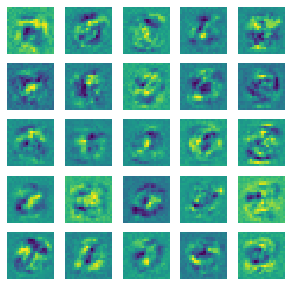

In [34]:
image_weights = pred_theta1[:, 1:].copy()

_, ax = plt.subplots(5,5,figsize=(5,5))
image = 0
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(image_weights[image].reshape((20,20), order = 'F'))          
        ax[i,j].axis('off')
        image+=1